# Tokenizer evaluation

In [1]:
import torch
from torch.utils.data import DataLoader

from predict import complete_sentence
from transformer.transformer import Transformer

PRETRAINED_PATH = "tokenization/pretrained"
MODELS_PATH = "models"

In [2]:
def plot_metric(x_labels, values, title, ylabel):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel('Tokenizer')
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.show()

## Load models and tokenizers

In [3]:
tokenizers_ids = {
    "bielik": "speakleash/Bielik-1.5B-v3",
    "mistral": "mistralai/Mistral-7B-v0.3",
    "bocian_bpe": PRETRAINED_PATH + "/bocian_tokenizer",
    "bocian_bpe_sp": PRETRAINED_PATH + "/bocian_tokenizer_sp",
    "whitespace": PRETRAINED_PATH + "/whitespace_tokenizer",
}

In [4]:
def load_tokenizer(path):
    tokenizer = AutoTokenizer.from_pretrained(path)

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    return tokenizer

In [5]:
from transformers import AutoTokenizer, PreTrainedTokenizerBase

tokenizers: dict[str, PreTrainedTokenizerBase] = {k: load_tokenizer(v) for k, v in tokenizers_ids.items()}

In [6]:
def clean_state_dict(state_dict):
    """
    Cleanup state dict.

    As the model was trained using DataParallel, the state dict keys are prefixed with 'module.' and may contain '._orig_mod'.
    """
    new_state_dict = {}
    for k, v in state_dict['model_state_dict'].items():
        new_k = k.replace('module.', '').replace('._orig_mod', '')
        new_state_dict[new_k] = v
    return new_state_dict

In [7]:
config = {
    "n_blocks": 12,
    "num_heads": 8,
    "seq_len": 512,
    "d_model": 1024,
    "d_ff": 4096
}

In [8]:
def load_model(path, vocab_size):
    model = Transformer(vocab_size=vocab_size, **config)
    state_dict = clean_state_dict(torch.load(path, map_location='cpu'))
    model.load_state_dict(state_dict)
    return model

In [9]:
models = {
    k: load_model(MODELS_PATH + "/best_tokenizers_" + k + ".pt", vocab_size=tokenizers[k].vocab_size)
    for k in tokenizers.keys()
}

## Evaluation

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
metrics = ['token_perplexity', 'char_perplexity', 'word_perplexity', 'evaluation_time_sec']
results = {k: {} for k in tokenizers.keys()}

In [12]:
import re
import time

from config import IGNORE_INDEX
from transformer.dataset import prepare_mask
from process import process_dataset
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for slug, tokenizer, model in zip(tokenizers.keys(), tokenizers.values(), models.values()):
    start_time = time.time()
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_tokens = 0

    dataset = process_dataset(tokenizer, ["speakleash_dataset/wolne_lektury_corpus.jsonl.zst"]).with_format('torch')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    metrics_cum = torch.zeros(4, device=device)

    with torch.no_grad(), tqdm(total=len(dataloader), desc=f"Evaluating {slug}") as pbar:
        for item in dataloader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)

            inputs = input_ids[..., :-1]
            targets = input_ids[..., 1:].clone()

            mask = prepare_mask(attention_mask[..., :-1])

            target_attention = attention_mask[..., 1:]
            targets[target_attention == 0] = IGNORE_INDEX

            output = model(inputs, mask)

            logits = output.reshape(-1, output.size(-1))
            flat_targets = targets.reshape(-1)

            loss = loss_fn(logits, flat_targets)

            num_valid_tokens = (flat_targets != -100).sum()
            batch_nll = loss * num_valid_tokens

            metrics_cum[0] += batch_nll
            metrics_cum[1] += num_valid_tokens

            batch_word_count = 0
            batch_char_count = 0

            batch_target_ids = input_ids[..., 1:]

            for ids, attn in zip(batch_target_ids.cpu(), target_attention.cpu()):
                valid_len = int(attn.sum().item())
                if valid_len == 0:
                    continue

                decoded = tokenizer.decode(ids[:valid_len], skip_special_tokens=True)

                words_in_seq = len(re.findall(r'\w+', decoded, re.UNICODE))
                chars_in_seq = len(decoded.replace(" ", ""))

                batch_word_count += words_in_seq
                batch_char_count += chars_in_seq

            metrics_cum[2] += batch_word_count
            metrics_cum[3] += batch_char_count

            pbar.update(1)

    total_val_nll = metrics_cum[0].item()
    total_tokens = metrics_cum[1].item()
    total_words = metrics_cum[2].item()
    total_chars = metrics_cum[3].item()

    results[slug]['token_perplexity'] = torch.exp(torch.tensor(total_val_nll / total_tokens)).item()
    results[slug]['char_perplexity'] = torch.exp(torch.tensor(total_val_nll / total_chars)).item()
    results[slug]['word_perplexity'] = torch.exp(torch.tensor(total_val_nll / total_words)).item()
    results[slug]['evaluation_time_sec'] = time.time() - start_time

Evaluating bielik:   0%|          | 0/1054 [00:00<?, ?it/s]

Evaluating mistral:   0%|          | 0/1647 [00:00<?, ?it/s]

Evaluating bocian_bpe:   0%|          | 0/1002 [00:00<?, ?it/s]

Evaluating bocian_bpe_sp:   0%|          | 0/939 [00:00<?, ?it/s]

Evaluating whitespace:   0%|          | 0/737 [00:00<?, ?it/s]

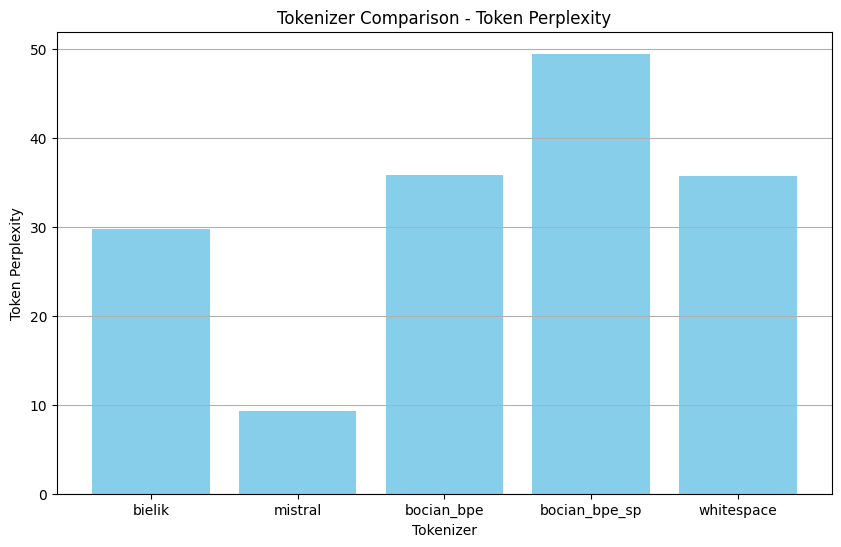

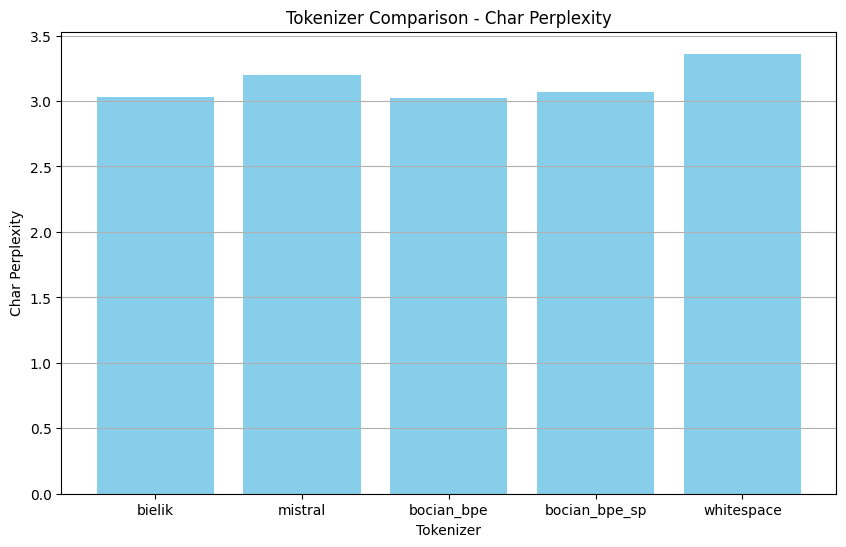

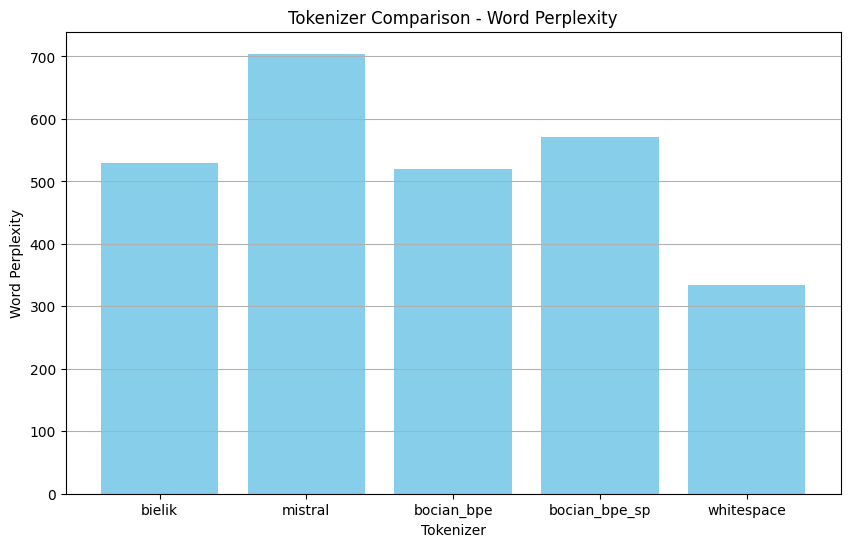

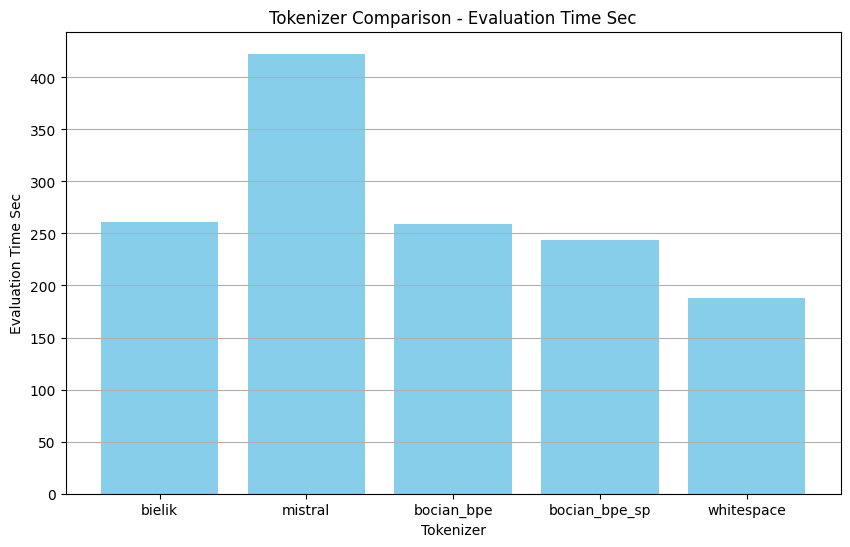

In [22]:
import matplotlib.pyplot as plt

for metric in metrics:
    plot_metric(
        x_labels=list(results.keys()),
        values=[results[slug][metric] for slug in results.keys()],
        title=f'Tokenizer Comparison - {metric.replace("_", " ").title()}',
        ylabel=metric.replace("_", " ").title()
    )

In [23]:
EVALUATION_DATASET_PATHS = [
    # This is the dataset that WAS NOT used during training
    "speakleash_dataset/tekstowo_pl_corpus.jsonl.zst"
]

In [24]:
tokens_count = {}

for slug, tokenizer in tokenizers.items():
    # Here another dataset is used for
    dataset = process_dataset(tokenizer, EVALUATION_DATASET_PATHS).with_format('torch')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    total_token_count = 0

    for item in dataloader:
        input_ids = item['input_ids']
        total_token_count += item['attention_mask'].sum().item()

    tokens_count[slug] = total_token_count

tokens_count

{'bielik': 19500645,
 'mistral': 29813808,
 'bocian_bpe': 18454502,
 'bocian_bpe_sp': 16102156,
 'whitespace': 12310659}

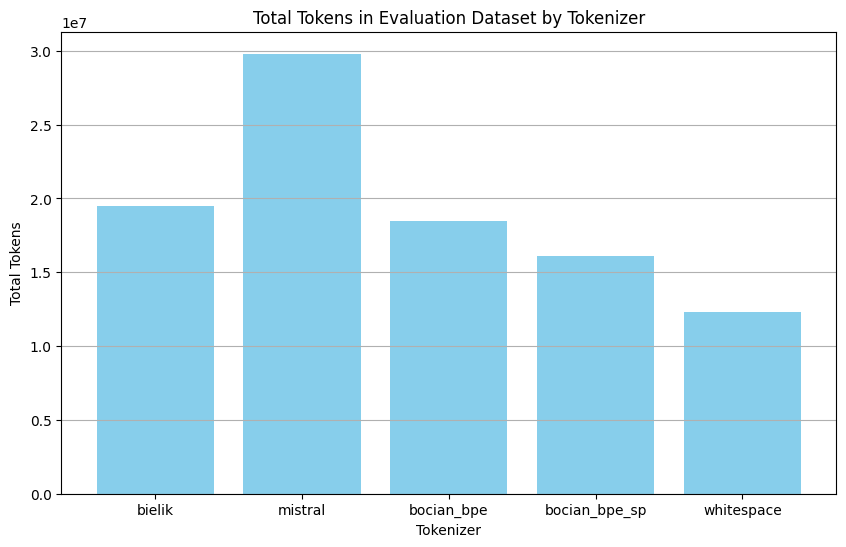

In [25]:
plot_metric(
    x_labels=list(tokens_count.keys()),
    values=[tokens_count[slug] for slug in tokens_count.keys()],
    title='Total Tokens in Evaluation Dataset by Tokenizer',
    ylabel='Total Tokens'
)

## OOV Count

In [26]:
dataset = process_dataset(tokenizers['whitespace'], EVALUATION_DATASET_PATHS).with_format('torch')
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

oov_count = 0

for item in dataloader:
    input_ids = item['input_ids']
    attention_mask = item['attention_mask']

    oov_count += (input_ids == tokenizers['whitespace'].unk_token_id).sum().item()

print(f"OOV Count (Whitespace Tokenizer): {oov_count}")
print(f"OOV Rate: {oov_count / sum(tokens_count.values()):.6f}")

OOV Count (Whitespace Tokenizer): 1765947
OOV Rate: 0.018361


In [27]:
prompts = [
    "Pewnego razu w małym miasteczku",
    "W dalekiej galaktyce, gdzie gwiazdy świecą jaśniej",
    "Na skraju lasu stała stara, opuszczona chatka",
    "Wielki wybuch zapoczątkował powstanie wszechświata",
    "Podróż przez czas i przestrzeń była marzeniem ludzkości"
]

In [28]:
generated_texts = {k : [] for k in tokenizers.keys()}
number_of_tokens_per_word = {k: 0 for k in tokenizers.keys()}
percentage_encoded_directly = {k: 0.0 for k in tokenizers.keys()}

for slug, tokenizer, model in zip(tokenizers.keys(), tokenizers.values(), models.values()):

    direct_token_count = 0
    total_words = 0
    total_tokens = 0
    unk_id = getattr(tokenizer, "unk_token_id", None)

    for prompt in prompts:
        input_ids = tokenizer.encode(prompt, return_tensors='pt')[..., :-1].to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        model.to(device)
        model.eval()

        with torch.no_grad():
            ids, text = complete_sentence(model, input_ids, attention_mask, tokenizer, max_new_tokens=50)

        words = re.findall(r'\w+', text[0], re.UNICODE)
        total_words += len(words)
        for w in words:
            encoded = tokenizer.encode(w, add_special_tokens=False)
            if len(encoded) == 1 and (unk_id is None or encoded[0] != unk_id):
                direct_token_count += 1

        total_tokens += len(ids[0])

    number_of_tokens_per_word[slug] = total_tokens / total_words if total_words > 0 else 0.0
    percentage_encoded_directly[slug] = (direct_token_count / total_words) * 100.0 if total_words > 0 else 0.0

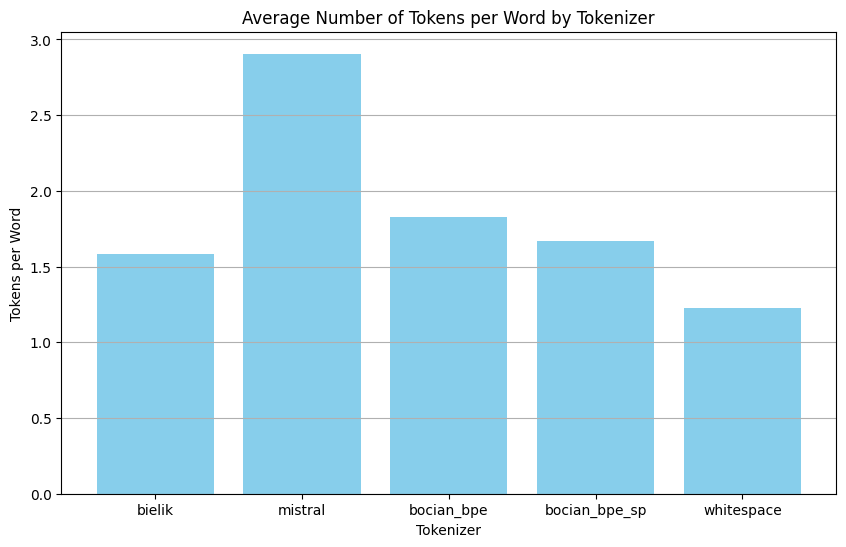

In [29]:
plot_metric(
    x_labels=list(number_of_tokens_per_word.keys()),
    values=[number_of_tokens_per_word[slug] for slug in number_of_tokens_per_word.keys()],
    title='Average Number of Tokens per Word by Tokenizer',
    ylabel='Tokens per Word'
)

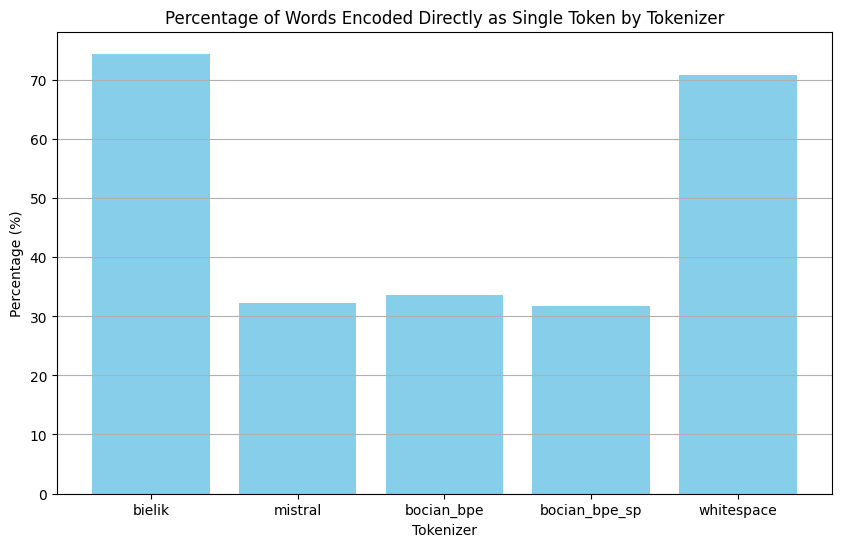

In [30]:
plot_metric(
    x_labels=list(percentage_encoded_directly.keys()),
    values=[percentage_encoded_directly[slug] for slug in percentage_encoded_directly.keys()],
    title='Percentage of Words Encoded Directly as Single Token by Tokenizer',
    ylabel='Percentage (%)'
)